In [652]:
# %pip install xgboost
# %pip install seaborn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from IPython.core.display import Image
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib.image import imread

In [653]:
data = pd.read_csv('data.csv')

X_questions = data.iloc[:, 2:182] # Id e data de nascimento são irrelevantes
X_questions = X_questions.drop('date_visit', axis=1) # Data de visita não é relevante
X_questions = X_questions.drop(X_questions.columns[[46, 133, 158, 161]], axis=1) # Essas colunas são constantes

X_drugs = data.iloc[:, 185:]
X_drugs = X_drugs.drop(X_drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                        142,143,148,151,152]], axis=1) # Essas colunas são constantes

X_random = np.random.rand(X_questions.shape[0], 1) # Para comparar a perfomance do modelo
X_random = pd.DataFrame(X_random)
X = np.concatenate((X_questions, X_drugs), axis=1) # A junção das duas tabelas
X = pd.DataFrame(X)

In [654]:
Y = data.iloc[:, 182:185]

y_vas30 = pd.DataFrame(Y.iloc[:, 0:1].values.ravel())
y_vas50 = pd.DataFrame(Y.iloc[:, 1:2].values.ravel())
y_gic = pd.DataFrame(Y.iloc[:, 2:3].values.ravel())

In [655]:
y_perceived = np.logical_or(y_vas30, y_vas50)
y_perceived = y_perceived.astype(int)
y_perceived = pd.DataFrame(y_perceived)

y = np.logical_and(y_perceived, y_gic)
y = y.astype(int)
y = pd.DataFrame(y)

In [656]:
print(f"A porcentagem de casos positivos em y_gic é {(np.sum(y_gic.values)/y_gic.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas30 é {(np.sum(y_vas30.values)/y_vas30.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas50 é {(np.sum(y_vas50.values)/y_vas50.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_perceived é {(np.sum(y_perceived.values)/y_perceived.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y é {(np.sum(y.values)/y.shape[0])*100:.2f}%")

A porcentagem de casos positivos em y_gic é 28.96%
A porcentagem de casos positivos em y_vas30 é 43.84%
A porcentagem de casos positivos em y_vas50 é 35.84%
A porcentagem de casos positivos em y_perceived é 43.84%
A porcentagem de casos positivos em y é 15.04%


In [657]:
print(y.shape)
zero_rows = y.index[(y == 0).all(axis=1)] # Achando os indices das linhas que tem y=0
# Selecionando aleatoriamente uma porcentagem dessas linhas para deletar
# delete_rows = np.random.choice(zero_rows, size=int(len(zero_rows)/1000), replace=False)
delete_rows = np.random.choice(zero_rows, size=int(len(zero_rows)/1.25), replace=False)
# delete_rows = np.random.choice(zero_rows, size=int(len(zero_rows)/1.04), replace=False)

# Deletando as linhas selecionadas de todos os conjuntos de features
X = X.drop(delete_rows)
X_drugs = X_drugs.drop(delete_rows)
X_questions = X_questions.drop(delete_rows)
X_random = np.delete(X_random, delete_rows, axis=0)

# Deletando as linhas selecionadas de todos os conjuntos targets
y_gic = y_gic.drop(delete_rows)
y_vas30 = y_vas30.drop(delete_rows)
y_vas50 = y_vas50.drop(delete_rows)
y_perceived = y_perceived.drop(delete_rows)
y = y.drop(delete_rows)

print(X.shape)
print(X_questions.shape)
print(X_drugs.shape)
print(y.shape)

(625, 1)
(201, 312)
(201, 175)
(201, 137)
(201, 1)


In [658]:
print(f"A porcentagem de casos positivos em y_gic é {(np.sum(y_gic.values)/y_gic.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas30 é {(np.sum(y_vas30.values)/y_vas30.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas50 é {(np.sum(y_vas50.values)/y_vas50.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_perceived é {(np.sum(y_perceived.values)/y_perceived.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y é {(np.sum(y.values)/y.shape[0])*100:.2f}%")

A porcentagem de casos positivos em y_gic é 56.22%
A porcentagem de casos positivos em y_vas30 é 61.69%
A porcentagem de casos positivos em y_vas50 é 49.25%
A porcentagem de casos positivos em y_perceived é 61.69%
A porcentagem de casos positivos em y é 46.77%


In [659]:
# Codificando as variáveis categóricas
le = LabelEncoder()
for col in X_questions.columns:
    if X_questions[col].dtype == 'bool':
        X_questions[col] = le.fit_transform(X_questions[col])

for col in X_drugs.columns:
    if X_drugs[col].dtype == 'bool':
        X_drugs[col] = le.fit_transform(X_drugs[col])

for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = le.fit_transform(X[col])

# Imputando os valores que faltam
imp = SimpleImputer(strategy='mean')
imp.fit(X_questions)
X_questions = imp.transform(X_questions)

imp = SimpleImputer(strategy='mean')
imp.fit(X_drugs)
X_drugs = imp.transform(X_drugs)

imp = SimpleImputer(strategy='mean')
imp.fit(X)
X = imp.transform(X)

# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_drugs = scaler.fit_transform(X_drugs)
X_questions = scaler.fit_transform(X_questions)
X_random = scaler.fit_transform(X_random)

X = pd.DataFrame(X)
X_drugs = pd.DataFrame(X_drugs)
X_questions = pd.DataFrame(X_questions)
X_random = pd.DataFrame(X_random)

y_gic = pd.DataFrame(y_gic)
y_vas30 = pd.DataFrame(y_vas30)
y_vas50 = pd.DataFrame(y_vas50)
y_perceived = pd.DataFrame(y_perceived)
y = pd.DataFrame(y)

In [660]:
def trainClassifier(X, y, clf, print_accuracy=False):
    kf = KFold(n_splits=5)
    empirical_losses = []
    test_losses = []
    empirical_accuracies = []
    test_accuracies = []

    for train_indices, test_indices in kf.split(X):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

        clf.fit(X_train, y_train) # classificador generico

        empirical_loss = log_loss(y_train, clf.predict(X_train))
        test_loss = log_loss(y_test, clf.predict(X_test))

        empirical_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_test, y_test)

        empirical_losses.append(empirical_loss)
        test_losses.append(test_loss)

        empirical_accuracies.append(empirical_accuracy)
        test_accuracies.append(test_accuracy)

    empirical_loss = np.mean(empirical_losses)
    test_loss = np.mean(test_losses)

    empirical_accuracy = np.mean(empirical_accuracies) * 100
    test_accuracy = np.mean(test_accuracies) * 100

    if print_accuracy:
        print(f"empirical_accuracy: {empirical_accuracy: .2f}% | test_accuracy: {test_accuracy: .2f}% ")

    return (empirical_loss, test_loss, test_accuracy)

def trainXGBBoostingClassifier(X, y, max_depth=0, gamma=0.0, print_accuracy=False, print_importance=False):
    clf = xgb.XGBClassifier(max_depth=max_depth,  gamma=gamma, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
    
    if print_importance:
        clf.fit(X, y)
        feat_imp = pd.Series(clf.get_booster().get_fscore())
        feat_imp.index = pd.Index(feat_imp.index)
        feat_imp.sort_values(ascending=False, inplace=True)
        feat_imp.plot(kind='bar', title='Importância da feature', width=0.8, figsize=(20,10))
        plt.ylabel('Avaliação de importância da feature')
        
    return trainClassifier(X, y, clf, print_accuracy)

def trainMLPClassifier(X, y, hidden_layer_size=0, print_accuracy=False):
    clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), solver='sgd', learning_rate_init=0.01,
                        max_iter=2000, verbose=False)
    return trainClassifier(X, y, clf, print_accuracy)

def trainRandomForestClassifier(X, y, max_depth=0, print_accuracy=False):
    clf =clf = RandomForestClassifier(n_estimators=1000, max_depth=max_depth)
    return trainClassifier(X, y, clf, print_accuracy)

def createPlotDir(alg_name):
    if not os.path.exists(f"plots"):
        os.mkdir(f"plots")

    if not os.path.exists(f"plots/{alg_name}"):
        os.mkdir(f"plots/{alg_name}/")

def savePlot(data, alg_name, filename):
    x = sorted(data.keys())
    empirical_losses = [data[key][0] for key in x]
    test_losses = [data[key][1] for key in x]

    legend = ['test loss', 'empirical loss']
    plt.ylim((0,30))
    plt.grid()
    plt.plot(x, test_losses, color='blue', linestyle='dashed')
    plt.plot(x, empirical_losses, color='blue')
    plt.legend(legend)

    plt.savefig(f'plots/{alg_name}/{filename}.png')
    plt.clf() 

In [661]:
def plotCapacityGraphsForXGBoost(X, y, filename, max_depth, print_accuracy=False):
    gamma = 0
    createPlotDir('xgboost')

    data = dict()
    for depth in range(1, max_depth+1):
        print(f"{(depth/max_depth)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss, test_accuracy) = trainXGBBoostingClassifier(X, y, max_depth=depth, gamma=gamma, print_accuracy=print_accuracy)
        data[depth] = (empirical_loss, test_loss)
   
    savePlot(data, 'xgboost', filename)

max_depth = 10
plotCapacityGraphsForXGBoost(X, y, "x", max_depth) # Adicionar X_drugs parece não ter efeito
plotCapacityGraphsForXGBoost(X_questions, y, "x_questions", max_depth, print_accuracy=False) # Resultado diferente do aleatorio mas ainda sim
plotCapacityGraphsForXGBoost(X_drugs, y_gic, "x_drugs", max_depth) # X_drugs parece ter nenhum poder preditivo
plotCapacityGraphsForXGBoost(X_random, y, "x_random", max_depth, print_accuracy=False)

In [662]:
def plotCapacityGraphsForRandomForest(X, y, filename, max_depth):
    gamma = 0
    createPlotDir('random_forest')

    data = dict()
    for depth in range(1, max_depth+1):
        print(f"{(depth/max_depth)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss, test_accuracy) = trainRandomForestClassifier(X, y, max_depth=depth)
        data[depth] = (empirical_loss, test_loss)
   
    savePlot(data, 'random_forest', filename)

max_depth = 20
plotCapacityGraphsForRandomForest(X, y, "x", max_depth)
plotCapacityGraphsForRandomForest(X_questions, y, "x_questions", max_depth)
plotCapacityGraphsForRandomForest(X_drugs, y, "x_drugs", max_depth)
plotCapacityGraphsForRandomForest(X_random, y, "x_random", max_depth)

In [663]:
_ = trainRandomForestClassifier(X, y, max_depth=3, print_accuracy=True)
_ =trainRandomForestClassifier(X_random, y, max_depth=3, print_accuracy=True)

In [664]:
_ = trainXGBBoostingClassifier(X_questions, y, max_depth=3, gamma=0.7, print_accuracy=True, print_importance=False)
_ = trainXGBBoostingClassifier(X_random, y, max_depth=3, gamma=0.7, print_accuracy=True, print_importance=False)

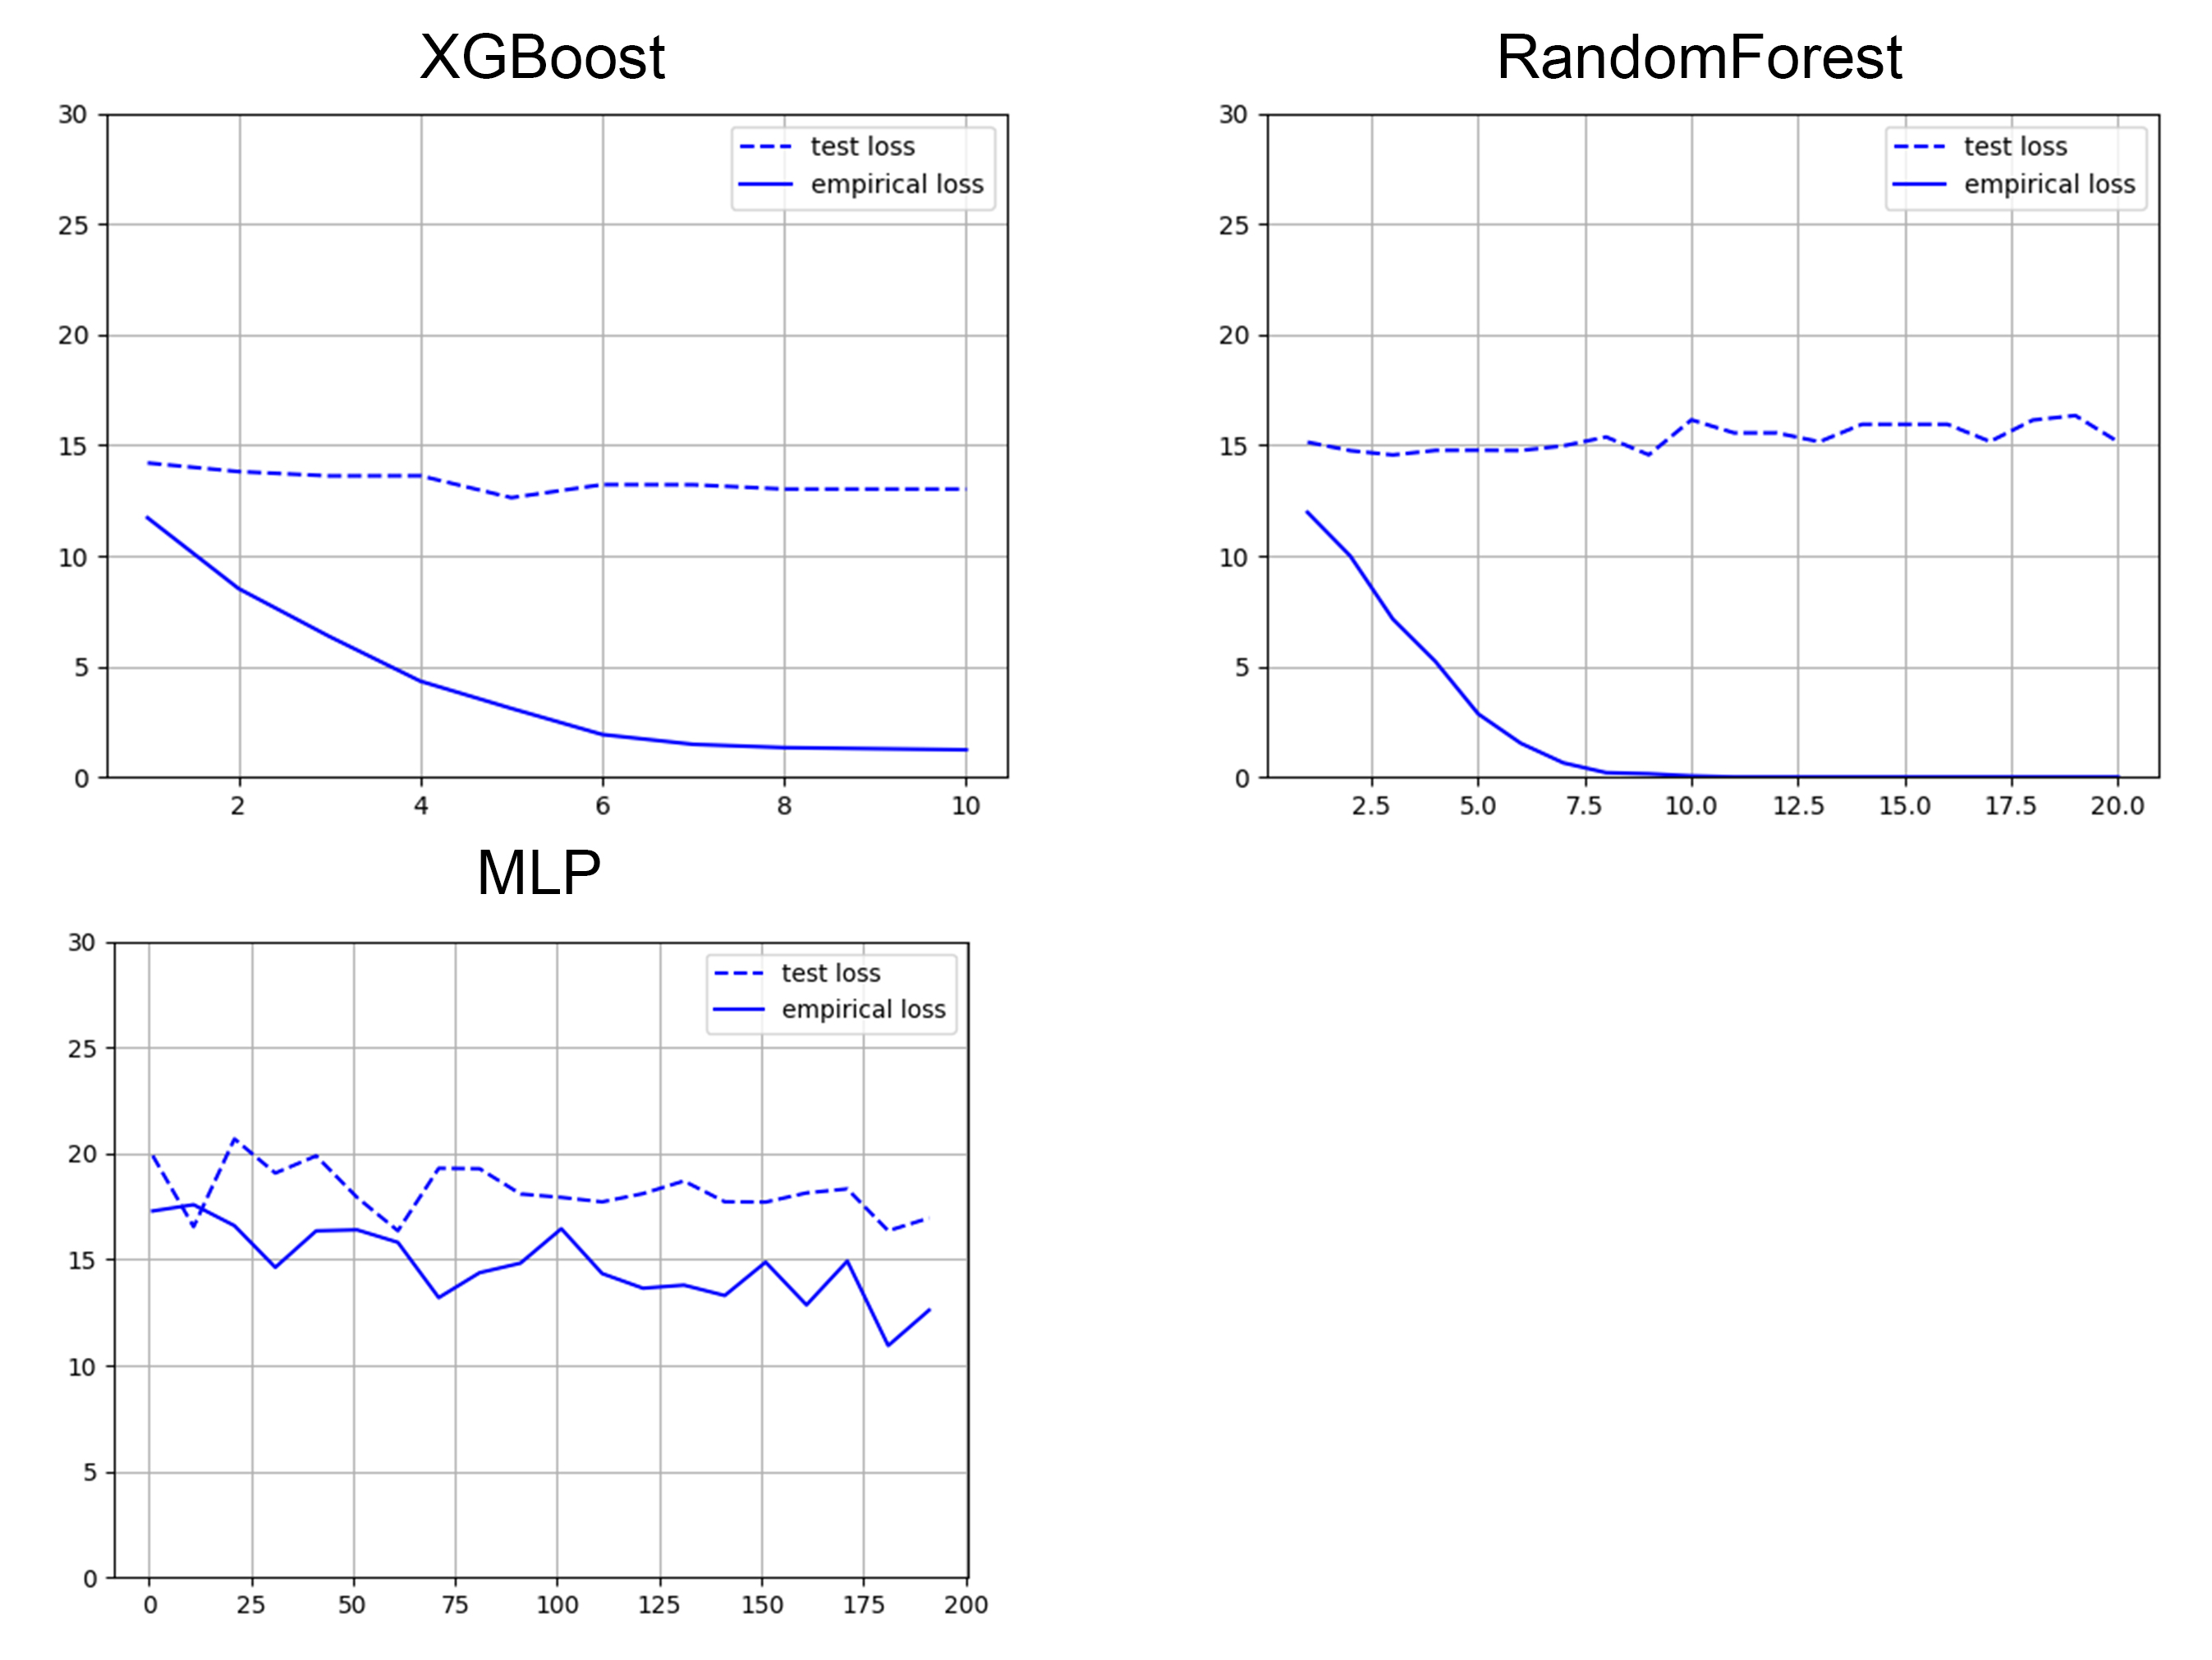

In [665]:
Image(filename='plots/manual/models_capacity_x.jpg')

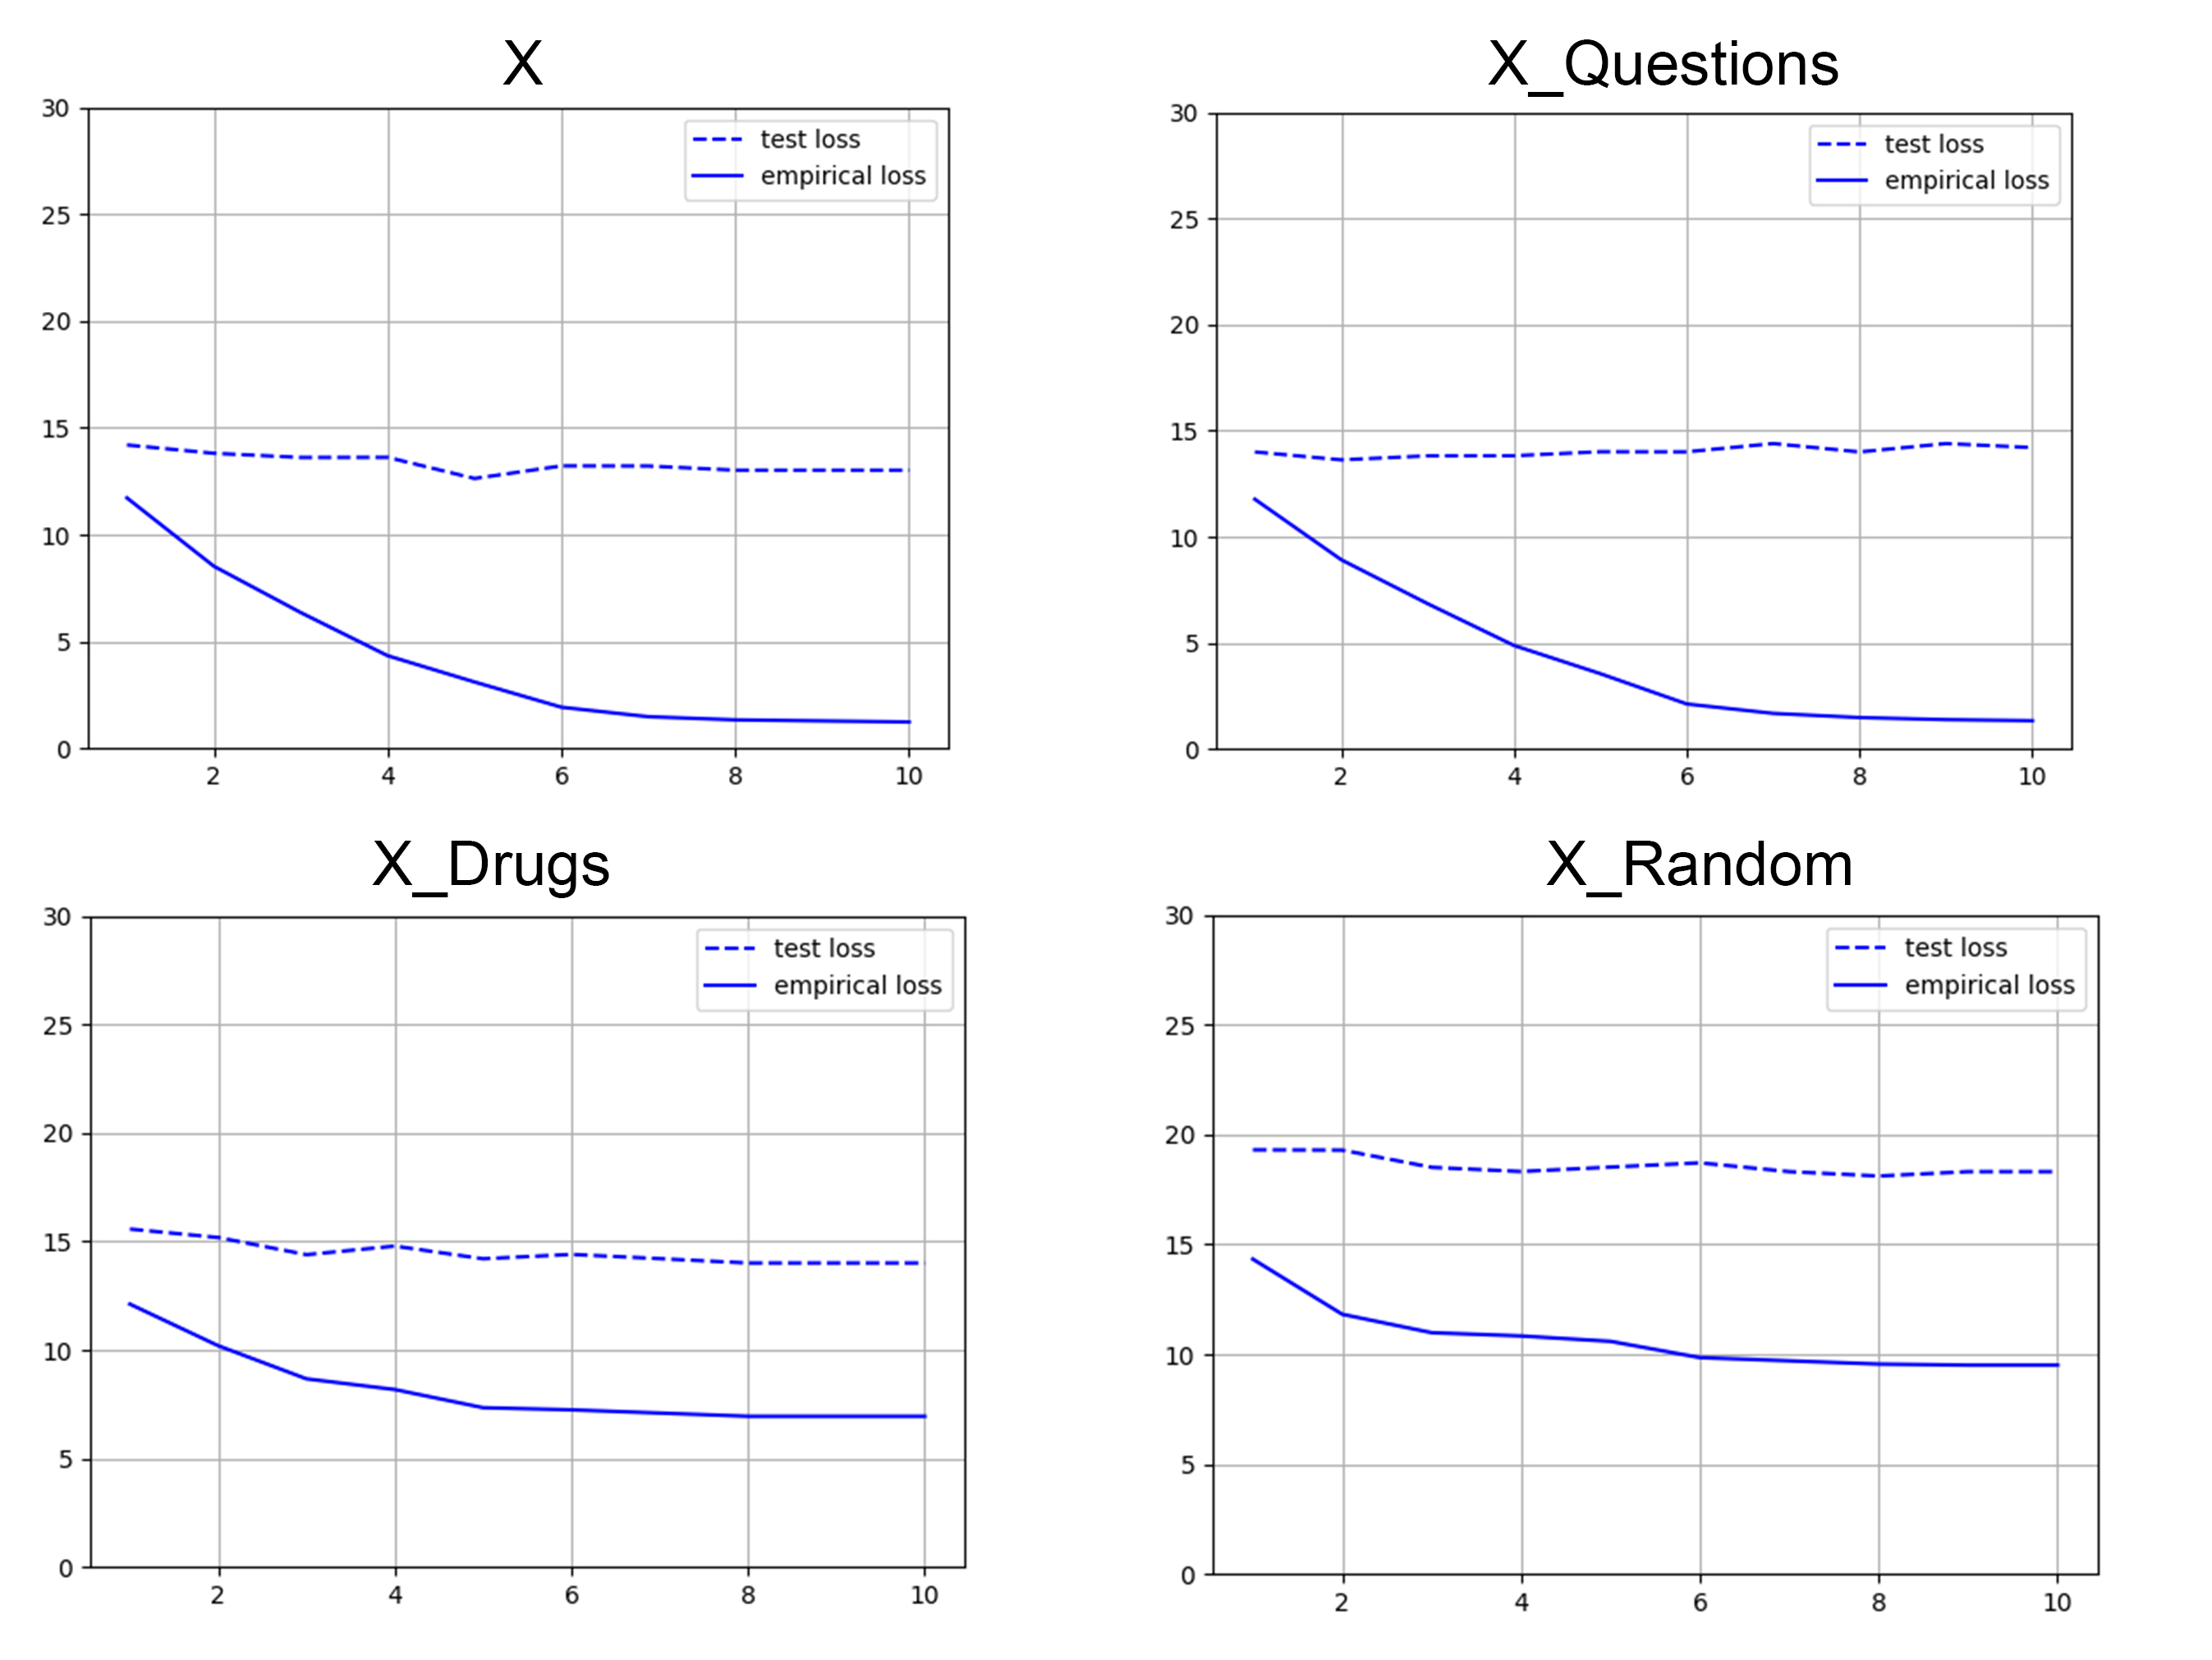

In [666]:
Image(filename='plots/manual/xgboost_features.jpg')

In [667]:
def meanConfusionMatrix(X, y, name, test_accuracy):
    k = 20
    mean_confusion_matrix = np.zeros((2,2))
    kfold = KFold(n_splits=k, shuffle=True)

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf = xgb.XGBClassifier(max_depth=3,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mean_confusion_matrix += confusion_matrix(y_test, y_pred)

    mean_confusion_matrix /= k
    sns.set(font_scale=1.4)
    sns.heatmap(mean_confusion_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='.2g')

    plt.title(name)
    plt.xlabel(f"Categoria predita ({test_accuracy:.2f}% de acurácia no teste)")
    plt.ylabel('Categoria real')
    plt.show()

# test_accuracy = trainXGBBoostingClassifier(X_random, y, max_depth=3, gamma=0.7, print_accuracy=True, print_importance=False)
# test_accuracy = test_accuracy[2]
# meanConfusionMatrix(X_random, y, 'Usando a distribuição balanceada (dados aleatórios)', test_accuracy)

In [ ]:
# Image(filename='plots/manual/confusion_matrix_negative_distribution.png')
image1 = imread('plots/manual/confusion_matrix_negative_distribution.png')
image2 = imread('plots/manual/confusion_matrix_balanced_distribution.png')
image3 = imread('plots/manual/confusion_matrix_positive_distribution.png')
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

image1 = imread('plots/xgboost/x.png')
image2 = imread('plots/xgboost/x_random.png')
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image1)
axs[0].set_title('Usando o conjunto de features X')
axs[1].imshow(image2)
axs[1].set_title('Usando o conjunto de features X_random')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
df = pd.read_csv("data.csv")
questions = df.iloc[:, 2:182]
questions = questions.drop('date_visit', axis=1)
questions = questions.drop(questions.columns[[46, 133, 158, 161]], axis=1)

drugs = data.iloc[:, 185:]
drugs = drugs.drop(drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                        142,143,148,151,152]], axis=1)

features = pd.concat([questions, drugs], axis=1)
features = list(features.columns)

test_accuracy = trainXGBBoostingClassifier(X_random, y, max_depth=3, gamma=0.7, print_accuracy=True)

clf = xgb.XGBClassifier(max_depth=3,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
clf.fit(X_questions, y)

feat_imp = pd.Series(clf.get_booster().get_fscore())
feat_imp.index = pd.Index(feat_imp.index)
feat_imp.sort_values(ascending=False, inplace=True)

x_plot = [ int(f.replace("f", "")) for f in feat_imp.index]
y_plot = [ feat_imp[f] for f in feat_imp.index]
x_plot = [features[feature_index] for feature_index in x_plot]

max_features = 40
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x_plot[:max_features], y_plot[:max_features], label="Importância da feature")
ax.set_ylabel("Avaliação de importância da feature")
plt.xticks(rotation=90)
ax.legend()
plt.show()